# Solutions for the `exercise_toycodes.ipynb` notebook

Uncomment and run the cells below (removing the `#`) when running this notebook on https://colab.research.google.com.

Alternatively, you can run this notebook locally with jupyter, provided that you have the `toycodes` subfolder from 
https://github.com/tenpy/tenpy_toycodes
in the same folder as your notebook.

In [1]:
#!pip install git+https://github.com/tenpy/tenpy_toycodes.git

# use `pip uninstall tenpy-toycodes` to remove it a gain.

This tutorial focuses on a set of toy codes (using only python with numpy + scipy) that provide a simple implementation of the various MPS algorithms.

You can add your code below by inserting additional cells as neccessary and running them (press Shift+Enter).

**DISCLAIMER**: the toy codes used are not optimized, and we only use very small bond dimensions here. For state-of-the-art MPS calculations (especially for cylinders towards 2D), `chi` should be significantly larger, often on the order of several 1000s.

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

# toy codes: a_mps.py

The file [a_mps.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/a_mps.py) defines a `SimpleMPS` class, that provides methods for expectation values and the entanglement entropy. You can initialize an inital product state MPS with the provided functions `init_FM_MPS` or `init_Neel_MPS`:

In [3]:
from toycodes.a_mps import init_FM_MPS, init_Neel_MPS

In [4]:
psi_FM = init_FM_MPS(L=10, d=2, bc='finite')
print(psi_FM)
SigmaZ = np.diag([1., -1.])
print(psi_FM.site_expectation_value(SigmaZ))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Exercise
Initialize a Neel state MPS. Print the `SigmaZ` expectation values.


Print the entanglement entropy. What do you expect? Why do you get so many numbers, and not just one?
Tipp: read the code ;-)

Extract the half-chain entanglement entropy, i.e., the entropy when cutting the chain into two equal-length halves.

In [5]:
psi_Neel = init_Neel_MPS(L=10, d=2, bc='finite')
print(psi_Neel.site_expectation_value(SigmaZ))

[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]


In [6]:
print(psi_Neel.entanglement_entropy())  # one for each bond!
print("half-chain entropy: ", psi_Neel.entanglement_entropy()[(psi_Neel.L - 1)//2])

[-0. -0. -0. -0. -0. -0. -0. -0. -0.]
half-chain entropy:  -0.0


# toy codes: b_model.py

The file [b_model.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/b_model.py) defines a `TFIModel` class representing the transverse field Ising model        
$$H = - J \sum_{i} \sigma^x_i \sigma^x_{i+1} - g \sum_{i} \sigma^z_i$$


that provides both in the form of bond-terms `H_bonds` (as required for TEBD) and in the form of an MPO `H_mpo`.
You can use `H_bonds` with `SimpleMPS.bond_expectation_values` to evalue the energy.


In [7]:
from toycodes.b_model import TFIModel

model = TFIModel(L=10, J=1., g=1.2, bc='finite')

print("<H_bonds> = ", psi_FM.bond_expectation_value(model.H_bonds))
print("energy:", np.sum(psi_FM.bond_expectation_value(model.H_bonds)))
# (make sure the model and state have the same length and boundary conditions!)

<H_bonds> =  [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
energy: -9.0


### Exercise

Check the energies for the Neel state and make sure it matches what you expect.

In [8]:
E = sum(psi_Neel.bond_expectation_value(model.H_bonds))
print("energy Neel:", E)

energy Neel: 9.0


# toy codes: c_tebd.py

The file [c_tebd.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/c_tebd.py) implements the TEBD algorithm. 

You can run TEBD with imaginary time evolutinon to find the ground state like this:

In [9]:
from toycodes.c_tebd import calc_U_bonds, run_TEBD

In [10]:
# assuming you defined a `model`

chi_max = 15

psi = init_FM_MPS(model.L, model.d, model.bc)
for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
    U_bonds = calc_U_bonds(model.H_bonds, dt)
    run_TEBD(psi, U_bonds, N_steps=100, chi_max=chi_max, eps=1.e-10)
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
# the `run_TEBD` modified `psi`, so we can now calculate the expectation values from it
print("final bond dimensions: ", psi.get_chi())
mag_x = np.sum(psi.site_expectation_value(model.sigmax))
mag_z = np.sum(psi.site_expectation_value(model.sigmaz))
print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))


dt = 0.10000: E = -13.8961677194781
dt = 0.01000: E = -13.9426155514706
dt = 0.00100: E = -13.9468077059314
dt = 0.00010: E = -13.9472289924180
dt = 0.00001: E = -13.9472711443175
final bond dimensions:  [2, 4, 8, 14, 15, 14, 8, 4, 2]
magnetization in X = 8.24005
magnetization in Z = 0.01748


### Exercise

Read the code of [c_tebd.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/c_tebd.py) and try to understand the general structure of how it works.


# toy codes: d_dmrg.py

The file [d_dmrg.py](https://github.com/jhauschild/WinterschoolBarcelona2021/blob/main/toycodes/d_dmrg.py) implements the DMRG algorithm.
It can be called like this:

In [11]:
from toycodes.d_dmrg import SimpleDMRGEngine, SimpleHeff2

In [12]:
chi_max = 15

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-10)
for i in range(10):
    E_dmrg = eng.sweep()
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))

sweep  1: E = -13.9497659535850
sweep  2: E = -13.9473400231317
sweep  3: E = -13.9473400175491
sweep  4: E = -13.9473400175491
sweep  5: E = -13.9473400175491
sweep  6: E = -13.9473400175491
sweep  7: E = -13.9473400175491
sweep  8: E = -13.9473400175491
sweep  9: E = -13.9473400175491
sweep 10: E = -13.9473400175491
final bond dimensions:  [2, 4, 8, 14, 15, 14, 8, 4, 2]
magnetization in X = 0.82406
magnetization in Z = -0.00000


### Exercise

Read the code of [d_dmrg.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/d_dmrg.py) and try to understand the general structure of how it works.


### Exercise

Compare running the code cells for DMRG and imaginary time evolution TEBD abovce for various parameters 
of `L`, `J`, `g`, and `bc`. Which one is faster? Do they always agree?

Note: 
The transverse field Ising model has a quantum phase transition at $g/J = 1.$,
from a ferro-magnetic phase (`g < J `) to a paramagnetic phase (`g > J`). We will map out the full phase diagram below.

In [13]:
model = TFIModel(L=20, J=1., g=1.0, bc='finite')

In [14]:
chi_max = 15

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-10)
for i in range(10):
    E_dmrg = eng.sweep()
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))

sweep  1: E = -25.0832904523074
sweep  2: E = -25.1078139618274
sweep  3: E = -25.1077971116273
sweep  4: E = -25.1077971116245
sweep  5: E = -25.1077971116245
sweep  6: E = -25.1077971116245
sweep  7: E = -25.1077971116245
sweep  8: E = -25.1077971116245
sweep  9: E = -25.1077971116245
sweep 10: E = -25.1077971116245
final bond dimensions:  [2, 4, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 8, 4, 2]
magnetization in X = 0.69494
magnetization in Z = -0.00000


# Infinite DMRG

The `SimpleDMRG` code also allows to run infinite DMRG, simply by replacing the `bc='finite'` for both the model and the MPS. Look at the implementation of `d_dmrg.py` to see where the differences are.

The `L` parameter now just indices the number of tensors insite the unit cell of the infinite MPS.
It has to be at least `2`, since we optimize 2 tensors at once in our DMRG code.
Further, note that we now use the `mean` to calculate densities of observables instead of extensive quantities (like L).

In [15]:
model = TFIModel(L=2, J=1., g=0.2, bc='infinite')

In [16]:
chi_max = 10

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-7)
for i in range(10):
    E_dmrg = eng.sweep()
    E = np.mean(psi.bond_expectation_value(model.H_bonds))
    print("sweep {i:2d}: E/L = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))

sweep  1: E/L = -1.0257321728263
sweep  2: E/L = -1.0101679578537
sweep  3: E/L = -1.0100254885278
sweep  4: E/L = -1.0100315048164
sweep  5: E/L = -1.2804073779119
sweep  6: E/L = -1.0104742300583
sweep  7: E/L = -1.0100252539846
sweep  8: E/L = -1.0100252539846
sweep  9: E/L = -1.0100252539846
sweep 10: E/L = -1.0100252539846
final bond dimensions:  [3, 3]
magnetization in X = 0.10051
magnetization in Z = 0.99491


### Exercise

Extend the following function `run_DMRG` to initialize an MPS compatible with the model, run DMRG on that MPS and return the corresponding state.

In [17]:
def run_DMRG(model, chi_max=50):
    print(f"runnning DMRG for L={model.L:d}, g={model.g:.2f}, bc={model.bc}, chi_max={chi_max:d}")
    #raise NotImplementedError("TODO: this is an Exercise!")
    
    psi = init_FM_MPS(model.L, model.d, model.bc)
    eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-10)
    for i in range(10):
        eng.sweep()
        E_bond = psi.bond_expectation_value(model.H_bonds)
        if model.bc == 'finite': 
            E = np.sum(E_bond)
        else:
            E = np.mean(E_bond)
        #print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))
    print(f"max chi ={max(psi.get_chi())}")
    return psi

### Exercise

Use that function to check that the average energy density and expectation values for infinite DMRG are independent of the unit cell length `L`.

In [18]:
model = TFIModel(L=2, J=1., g=0.2, bc='infinite')
psi = run_DMRG(model)
print(psi.bond_expectation_value(model.H_bonds))
print("\n")
model = TFIModel(L=4, J=1., g=0.2, bc='infinite')
psi = run_DMRG(model)
print(psi.bond_expectation_value(model.H_bonds))

runnning DMRG for L=2, g=0.20, bc=infinite, chi_max=50
max chi =6
[-1.01003 -1.01003]


runnning DMRG for L=4, g=0.20, bc=infinite, chi_max=50
max chi =5
[-1.01003 -1.01003 -1.01003 -1.01003]


### Exercise

Use the `run_DMRG` function above to plot expectation values as a function of `g` for fixed `J=1` with the following code.


Modify it to also plot the average expectation values of `sigmaz` and `sigmax` and the 
`sigmaz` correlation function between spin 0 and 20.

In [19]:
#gs = [0.1, 0.5, 1.0, 1.5, 2.0]
gs = np.linspace(0., 2., 21)
entropies = []
vals_X = []
vals_Z = []
corrs_ZZ = []


for g in gs:
    model = TFIModel(L=2, J=1., g=g, bc='infinite')
    psi = run_DMRG(model, chi_max=50)
    entropies.append(np.max(psi.entanglement_entropy()))
    vals_X.append(np.mean(psi.site_expectation_value(model.sigmax)))
    vals_Z.append(np.mean(psi.site_expectation_value(model.sigmaz)))
    corrs_ZZ.append(np.mean(psi.correlation_function(model.sigmaz, 0, model.sigmaz, 20)))

    

runnning DMRG for L=2, g=0.00, bc=infinite, chi_max=50
max chi =1
runnning DMRG for L=2, g=0.10, bc=infinite, chi_max=50
max chi =5
runnning DMRG for L=2, g=0.20, bc=infinite, chi_max=50
max chi =6
runnning DMRG for L=2, g=0.30, bc=infinite, chi_max=50
max chi =9
runnning DMRG for L=2, g=0.40, bc=infinite, chi_max=50
max chi =17
runnning DMRG for L=2, g=0.50, bc=infinite, chi_max=50
max chi =20
runnning DMRG for L=2, g=0.60, bc=infinite, chi_max=50
max chi =28
runnning DMRG for L=2, g=0.70, bc=infinite, chi_max=50
max chi =36
runnning DMRG for L=2, g=0.80, bc=infinite, chi_max=50
max chi =44
runnning DMRG for L=2, g=0.90, bc=infinite, chi_max=50
max chi =50
runnning DMRG for L=2, g=1.00, bc=infinite, chi_max=50
max chi =50
runnning DMRG for L=2, g=1.10, bc=infinite, chi_max=50
max chi =43
runnning DMRG for L=2, g=1.20, bc=infinite, chi_max=50
max chi =36
runnning DMRG for L=2, g=1.30, bc=infinite, chi_max=50
max chi =28
runnning DMRG for L=2, g=1.40, bc=infinite, chi_max=50
max chi =24

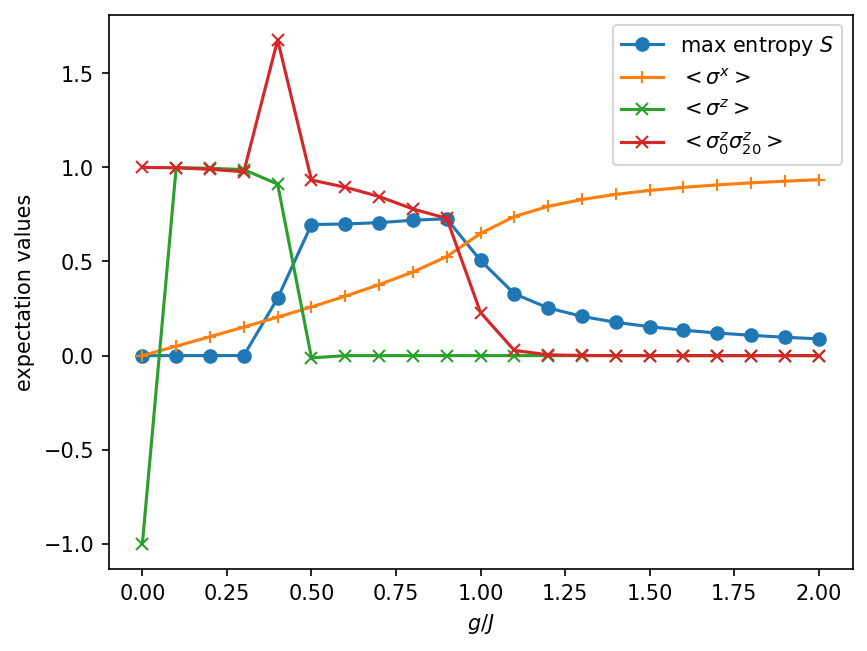

In [20]:
plt.plot(gs, entropies, marker='o', label='max entropy $S$')
# plot expecation values of sigmax and sigmaz as well
plt.plot(gs, vals_X, marker='+', label=r'$<\sigma^x>$')
plt.plot(gs, vals_Z, marker='x', label=r'$<\sigma^z>$')
plt.plot(gs, corrs_ZZ, marker='x', label=r'$<\sigma^z_0 \sigma^z_{20}>$')


plt.xlabel('$g/J$')
plt.ylabel('expectation values')
plt.legend(loc='best')


# Defining a new model: the XX chain

For the time evolution, we want to consider the XX chain in a staggered field, given by the Hamiltonian

$$ H = \sum_{i=0}^{N-2} (\sigma^x_i \sigma^x_{i+1} + \sigma^y_i \sigma^y_{i+1})  - h_s \sum_{i=0}^{N-1} (-1)^i \sigma^z_i 
     = 2 \sum_{i=0}^{N-2} (\sigma^+_i \sigma^-_{i+1} + \sigma^+_i \sigma^-_{i+1})  - h_s \sum_{i=0}^{N-1} (-1)^i \sigma^z_i
$$

for the usual Pauli matrices $\sigma^x, \sigma^y, \sigma^z$.

A Jordan-Wigner transformation maps the XX Chain to free fermions, which we can diagonalize exactly with a few lines of python codes that are given in [free_fermions_exact.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/free_fermions_exact.py)

In [21]:
from toycodes.free_fermions_exact import XX_model_ground_state_energy

print("E_exact = ", XX_model_ground_state_energy(L=10, h_staggered=0.))

E_exact =  -12.053348366664542


### Exercise

The following code implements the model for the XX Chain hamiltonian, but the MPO lacks some terms. Fill them in!


Tip: In Python, `(-1)**i` represents $(-1)^i$.


Compare the energies of DMRG and (imaginary) TEBD to check that you got it correct.
**Note** that you have to use the Neel state as initial state to be in the right charge sector:
the `|up up up ... up >` state already is an eigenstate of this Hamiltonian, so neither DMRG nor TEBD will modify it!

In [22]:
class XXChain:
    """Simple class generating the Hamiltonian of the 
    The Hamiltonian reads
    .. math ::
        H = - J \\sum_{i} \\sigma^x_i \\sigma^x_{i+1} - g \\sum_{i} \\sigma^z_i
    """
    def __init__(self, L, hs, bc='finite'):
        assert bc in ['finite', 'infinite']
        self.L, self.d, self.bc = L, 2, bc
        self.hs = hs
        self.sigmax = np.array([[0., 1.], [1., 0.]])  # Pauli X
        self.sigmay = np.array([[0., -1j], [1j, 0.]]) # Pauli Y
        self.sigmaz = np.array([[1., 0.], [0., -1.]]) # Pauli Z
        self.id = np.eye(2)
        self.init_H_bonds()
        self.init_H_mpo()

    def init_H_bonds(self):
        """Initialize `H_bonds` hamiltonian."""
        sx, sy, sz, id = self.sigmax, self.sigmay, self.sigmaz, self.id
        d = self.d
        nbonds = self.L - 1 if self.bc == 'finite' else self.L
        H_list = []
        for i in range(nbonds):
            hL = hR = 0.5 * self.hs
            if self.bc == 'finite':
                if i == 0:
                    hL = self.hs
                if i + 1 == self.L - 1:
                    hR = self.hs
            H_bond = np.kron(sx, sx) + np.kron(sy, sy)
            H_bond = H_bond - hL * (-1)**i * np.kron(sz, id) - hR * (-1)**(i+1) * np.kron(id, sz)
            # H_bond has legs ``i, j, i*, j*``
            H_list.append(np.reshape(H_bond, [d, d, d, d]))
        self.H_bonds = H_list

    # (note: not required for TEBD)
    def init_H_mpo(self):
        """Initialize `H_mpo` Hamiltonian."""
        w_list = []
        for i in range(self.L):
            w = np.zeros((4, 4, self.d, self.d), dtype=complex)
            w[0, 0] = w[3, 3] = self.id
            
            #raise NotImplementedError("add further entries here")
            w[0, 1] = self.sigmax
            w[0, 2] = self.sigmay
            w[0, 3] = - self.hs * (-1)**i * self.sigmaz
            w[1, 3] = self.sigmax
            w[2, 3] = self.sigmay
            
            w_list.append(w)
        self.H_mpo = w_list
        
model = XXChain(9, 4., bc='finite')

In [23]:
print("E_exact = ", XX_model_ground_state_energy(model.L, model.hs))

E_exact =  -37.92143925250613


In [24]:
chi_max = 100

psi = init_Neel_MPS(model.L, model.d, model.bc)  # important: Neel
for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
    U_bonds = calc_U_bonds(model.H_bonds, dt)
    run_TEBD(psi, U_bonds, N_steps=100, chi_max=chi_max, eps=1.e-10)
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))

dt = 0.10000: E = -37.6207943679329
dt = 0.01000: E = -37.8912899426555
dt = 0.00100: E = -37.9183076887500
dt = 0.00010: E = -37.9209995590774
dt = 0.00001: E = -37.9212690303092


In [25]:
# DMRG again
chi_max = 100
psi = init_Neel_MPS(model.L, model.d, model.bc)  # important: Neel!
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-10)
for i in range(10):
    eng.sweep()
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    #print(psi.get_chi())
    print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))

sweep  1: E = -37.9216146988834
sweep  2: E = -37.9214392525137
sweep  3: E = -37.9214392525061
sweep  4: E = -37.9214392525061
sweep  5: E = -37.9214392525061
sweep  6: E = -37.9214392525061
sweep  7: E = -37.9214392525061
sweep  8: E = -37.9214392525061
sweep  9: E = -37.9214392525061
sweep 10: E = -37.9214392525061


# Time evolution of the Neel state under the XX chain

We will now consider the Neel state as an initial state for (real-)time evolution, i.e., calculate
$$ \vert \psi(t)\rangle =e^{-i H t} \vert\uparrow \downarrow \uparrow \downarrow \dots\rangle$$
under the Hamiltonian of the XX chain (with staggered field).

Again, we can use the mapping to free fermions to calculate some quantities exactly.
We will focus on the half chain entanglement entropy and compare it to TEBD:


In [26]:
from toycodes.free_fermions_exact import XX_model_time_evolved_entropies

dt = 0.1
tmax = 4.
L = 50
hs = 0.
model = XXChain(L, hs)

times_exact = np.arange(0., tmax, dt)
S_exact = XX_model_time_evolved_entropies(L=L, h_staggered=hs, time_list=times_exact)

For reference, will will also compare to a TEBD run:

In [27]:
chi_max = 30

psi = init_Neel_MPS(L, 2, bc='finite')
U_bonds = calc_U_bonds(model.H_bonds, 1.j * dt) # here, imaginary dt = real time evolution
t = 0.
times_tebd = []
S_tebd = []
while t < tmax: 
    times_tebd.append(t)
    S_tebd.append(psi.entanglement_entropy()[(L-1)//2])
    print(f"t={t:.2f}")
    t += dt
    run_TEBD(psi, U_bonds, N_steps=1, chi_max=chi_max, eps=1.e-7)


t=0.00
t=0.10
t=0.20
t=0.30
t=0.40
t=0.50
t=0.60
t=0.70
t=0.80
t=0.90
t=1.00
t=1.10
t=1.20
t=1.30
t=1.40
t=1.50
t=1.60
t=1.70
t=1.80
t=1.90
t=2.00
t=2.10
t=2.20
t=2.30
t=2.40
t=2.50
t=2.60
t=2.70
t=2.80
t=2.90
t=3.00
t=3.10
t=3.20
t=3.30
t=3.40
t=3.50
t=3.60
t=3.70
t=3.80
t=3.90


# toy code: e_tdvp.py

The file [e_tdvp.py](https://github.com/tenpy/tenpy_toycodes/blob/main/toycodes/e_tdvp.py) implements the TDVP time evolution for finite MPS with the `SimpleTDVPEngine`.
It implements both the true TDVP with one-site updates in `sweep_one_site`, and `sweep_two_site` that allows to grow the bond dimension:



In [28]:
from toycodes.e_tdvp import SimpleTDVPEngine

In [29]:
chi_max = 30
t_switch = 1.

psi = init_Neel_MPS(L, 2, bc='finite')
eng = SimpleTDVPEngine(psi, model, chi_max=chi_max, eps=1.e-7)

t = 0.
times_tdvp = []
S_tdvp = []
while t < tmax: 
    times_tdvp.append(t)
    S_tdvp.append(psi.entanglement_entropy()[(L-1)//2])
    print(f"t={t:.2f}, chi_max = {max(psi.get_chi()):d}")
    t += dt
    if t < t_switch:
        eng.sweep_two_site(dt)
    else:
        eng.sweep_one_site(dt)

t=0.00, chi_max = 1


/home/johannes/postdoc/2022-08-29-ESI-Vienna/exercises_git/toycodes/e_tdvp.py:242: UserWarning: Trace of LinearOperator not available, it will be estimated. Provide `traceA` to ensure performance.
  return expm_multiply((-1.j*dt) * H, psi0)


t=0.10, chi_max = 4
t=0.20, chi_max = 10
t=0.30, chi_max = 12
t=0.40, chi_max = 18
t=0.50, chi_max = 23
t=0.60, chi_max = 28
t=0.70, chi_max = 30
t=0.80, chi_max = 30
t=0.90, chi_max = 30
t=1.00, chi_max = 30
t=1.10, chi_max = 30
t=1.20, chi_max = 30
t=1.30, chi_max = 30
t=1.40, chi_max = 30
t=1.50, chi_max = 30
t=1.60, chi_max = 30
t=1.70, chi_max = 30
t=1.80, chi_max = 30
t=1.90, chi_max = 30
t=2.00, chi_max = 30
t=2.10, chi_max = 30
t=2.20, chi_max = 30
t=2.30, chi_max = 30
t=2.40, chi_max = 30
t=2.50, chi_max = 30
t=2.60, chi_max = 30
t=2.70, chi_max = 30
t=2.80, chi_max = 30
t=2.90, chi_max = 30
t=3.00, chi_max = 30
t=3.10, chi_max = 30
t=3.20, chi_max = 30
t=3.30, chi_max = 30
t=3.40, chi_max = 30
t=3.50, chi_max = 30
t=3.60, chi_max = 30
t=3.70, chi_max = 30
t=3.80, chi_max = 30
t=3.90, chi_max = 30


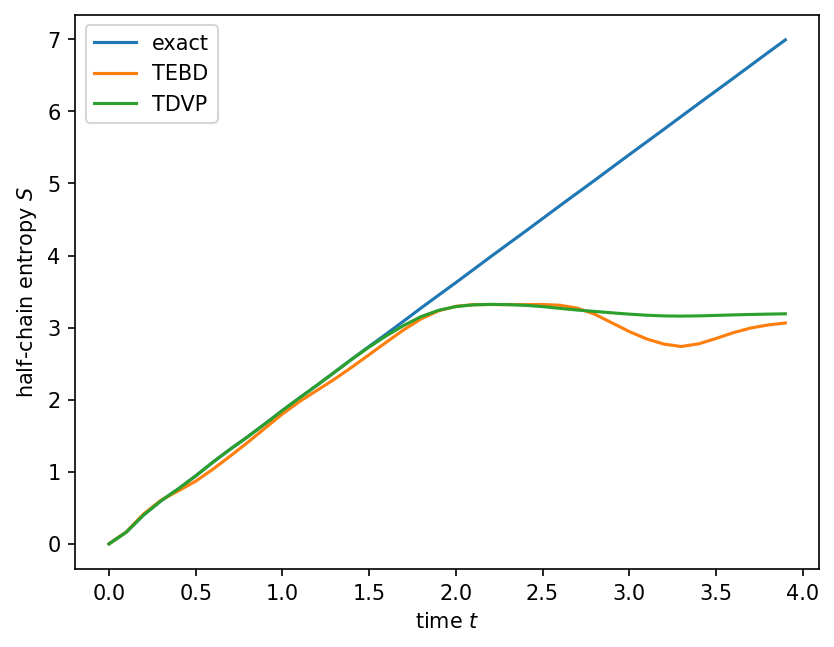

In [30]:
plt.plot(times_exact, S_exact, label="exact")
plt.plot(times_tebd, S_tebd, label="TEBD")
plt.plot(times_tdvp, S_tdvp, label="TDVP")

plt.xlabel('time $t$')
plt.ylabel('half-chain entropy $S$')
plt.legend(loc='best')

### Exercise

Read the code of `e_tdvp.py` and try to see the general structure of how it works.

### Exercise

Add curves for smaller (or larger) chi to the plot above. (It might take a little while to run for large chi...).

Try switching earlier or later from two-site to one-site TDVP.

What happens if you switch on the staggered field?


**NOTE**: You can avoid having to rerun the time evolution if you make copies of the results `S_tdvp` and similar lists.


In [31]:
chi_max = 10

psi = init_Neel_MPS(L, 2, bc='finite')
eng = SimpleTDVPEngine(psi, model, chi_max=chi_max, eps=1.e-7)

t = 0.
times_tdvp_chi_10 = []
S_tdvp_chi_10 = []
while t < tmax: 
    times_tdvp_chi_10.append(t)
    S_tdvp_chi_10.append(psi.entanglement_entropy()[(L-1)//2])
    print(f"t={t:.2f}, chi_max = {max(psi.get_chi()):d}")
    t += dt
    if t < t_switch:
        eng.sweep_two_site(dt)
    else:
        eng.sweep_one_site(dt)

t=0.00, chi_max = 1
t=0.10, chi_max = 4
t=0.20, chi_max = 10
t=0.30, chi_max = 10
t=0.40, chi_max = 10
t=0.50, chi_max = 10
t=0.60, chi_max = 10
t=0.70, chi_max = 10
t=0.80, chi_max = 10
t=0.90, chi_max = 10
t=1.00, chi_max = 10
t=1.10, chi_max = 10
t=1.20, chi_max = 10
t=1.30, chi_max = 10
t=1.40, chi_max = 10
t=1.50, chi_max = 10
t=1.60, chi_max = 10
t=1.70, chi_max = 10
t=1.80, chi_max = 10
t=1.90, chi_max = 10
t=2.00, chi_max = 10
t=2.10, chi_max = 10
t=2.20, chi_max = 10
t=2.30, chi_max = 10
t=2.40, chi_max = 10
t=2.50, chi_max = 10
t=2.60, chi_max = 10
t=2.70, chi_max = 10
t=2.80, chi_max = 10
t=2.90, chi_max = 10
t=3.00, chi_max = 10
t=3.10, chi_max = 10
t=3.20, chi_max = 10
t=3.30, chi_max = 10
t=3.40, chi_max = 10
t=3.50, chi_max = 10
t=3.60, chi_max = 10
t=3.70, chi_max = 10
t=3.80, chi_max = 10
t=3.90, chi_max = 10


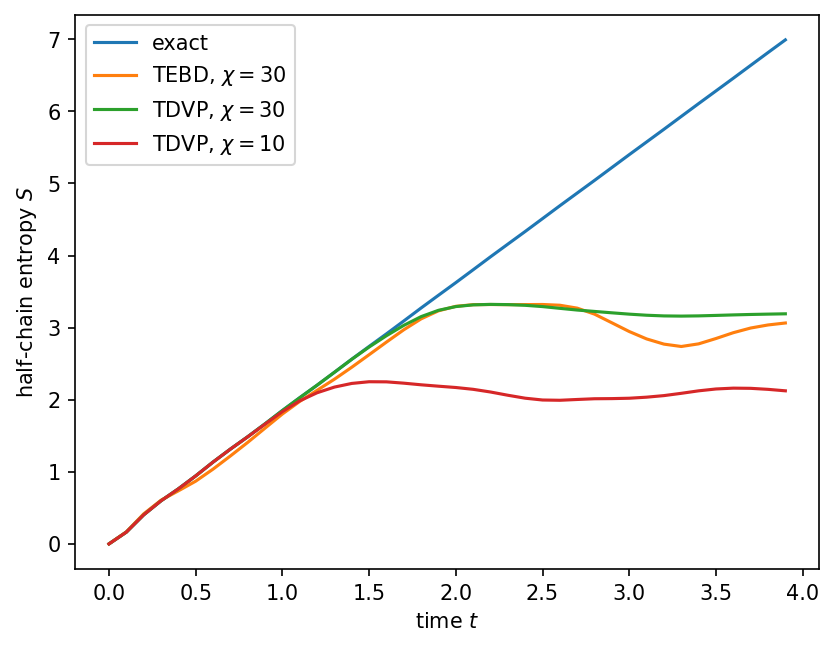

In [32]:
plt.plot(times_exact, S_exact, label="exact")
plt.plot(times_tebd, S_tebd, label=r"TEBD, $\chi=30$")
plt.plot(times_tdvp, S_tdvp, label=r"TDVP, $\chi=30$")
plt.plot(times_tdvp_chi_10, S_tdvp_chi_10, label=r"TDVP, $\chi=10$")


plt.xlabel('time $t$')
plt.ylabel('half-chain entropy $S$')
plt.legend(loc='best')

### Advanced exercises - if you're an expert and have time left ;-)


- Write a function to initialize an MPS which is a product of singlets on neighboring sites.
  Note that this state has non-trivial entanglement on every other bond!
- Obtain the ground state of the transverse field ising model at the critical point with DMRG.
  Try to plot the corrlation function as a function of `j-i`.
  What form does it have? Is an MPS a good ansatz for that?
- Calling `SimpleMPS.correlation_function` in a loop over `j` for fixed `i` is inefficient for large `j-i`. 
  Try to rewrite the correlation function to obtain the values for all `j>i` up to some cutoff in a single loop.
- Look at the light-cone after a local quench of the XX chain, similarly as is done in  `e_tdvp.example_TDVP_tf_ising_lightcone`. 
  How does the speed of the light cone change with the staggered field?